In [125]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np 

In [126]:
df = pd.read_csv("../input/ulabox-orders-with-categories-partials-2017/ulabox_orders_with_categories_partials_2017.csv")
df_copy = df.copy()
df.head()

,customer,order,total_items,discount%,weekday,hour,Food%,Fresh%,Drinks%,Home%,Beauty%,Health%,Baby%,Pets%
0,0,0,45,23.03,4,13,9.46,87.06,3.48,0.00,0.00,0.00,0.0,0.0
1,0,1,38,1.22,5,13,15.87,75.80,6.22,2.12,0.00,0.00,0.0,0.0
2,0,2,51,18.08,4,13,16.88,56.75,3.37,16.48,6.53,0.00,0.0,0.0
3,1,3,57,16.51,1,12,28.81,35.99,11.78,4.62,2.87,15.92,0.0,0.0
4,1,4,53,18.31,2,11,24.13,60.38,7.78,7.72,0.00,0.00,0.0,0.0


In [127]:
"""
    First we will prepare input for the model. 
    For now, we don't want to consider discount, customer number, order number, weekday and hour as an input for our clustering.
"""
df.columns

Index(['customer', 'order', 'total_items', 'discount%', 'weekday', 'hour',
       'Food%', 'Fresh%', 'Drinks%', 'Home%', 'Beauty%', 'Health%', 'Baby%',
       'Pets%'],
      dtype='object')

In [128]:
input = df.drop(["customer", "order", "discount%", "weekday", "hour"], axis=1)
input.head()

,total_items,Food%,Fresh%,Drinks%,Home%,Beauty%,Health%,Baby%,Pets%
0,45,9.46,87.06,3.48,0.00,0.00,0.00,0.0,0.0
1,38,15.87,75.80,6.22,2.12,0.00,0.00,0.0,0.0
2,51,16.88,56.75,3.37,16.48,6.53,0.00,0.0,0.0
3,57,28.81,35.99,11.78,4.62,2.87,15.92,0.0,0.0
4,53,24.13,60.38,7.78,7.72,0.00,0.00,0.0,0.0


In [129]:
"""
 Lets determine whether or not a given data-set contains clusters or not.
 We will use the Hopkins statistic for this. Ignore the method implementation.
 The value ranges between 0 and 1.
 The idea is simple – the closer the value to 1, the higher the likelihood of clusters.
"""

from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan

def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) # heuristic from article [1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

hopkins(input)

0.9609884701014505

In [130]:
# Using scikit-learn to perform K-Means clustering
from sklearn.cluster import KMeans
    
# Specify the number of clusters (4) and fit the data X
kmeans = KMeans(n_clusters=4, random_state=0).fit(input)

In [131]:
# Get the cluster centroids
print(kmeans.cluster_centers_)
    
# Get the cluster labels
print(kmeans.labels_)

[[40.27545857 20.63515286 50.07000422 14.33270715  7.28480603  3.47421569
   0.87005376  2.4617004   0.78969218]
 [14.44889893  5.41441276  3.20577922  9.14900621  6.50335968  2.51665443
   0.76562676 71.93480519  0.31248447]
 [25.25156043 13.88402497  6.22763004 62.01423492 10.51195763  3.13382448
   0.79607339  2.56898052  0.70862115]
 [32.98776209 35.813816    7.49456312 17.47898674 22.11997946 10.12833119
   1.61016175  3.52223962  1.62159093]]
[0 0 0 ... 2 2 1]


In [132]:
df["labels"] = kmeans.labels_
df.groupby(['customer', 'labels']).size()

customer  labels
0         0          3
1         0         18
          2          1
          3          1
2         2          1
                    ..
10234     1          1
10235     2          1
10236     3          1
10237     2          2
10238     1          1
Length: 13841, dtype: int64

* If we look closely, customer number 1 is spread across various clusters. We are here not to cluster the transactions but cluster the customers. 
* For now lets continue analyzing the clusters, we will come back to this again.


# The silhouette score
* The value of the silhouette coefﬁcient is between [-1, 1]. 
* A score of 1 denotes the best meaning that the data point is very compact within the cluster to which it belongs and far away from the other clusters.

In [133]:
# Calculate silhouette_score
from sklearn.metrics import silhouette_score

print(silhouette_score(input, kmeans.labels_))

0.26210907385342525


# The elbow method
* Using silhouette coefficients to determine K

/opt/conda/lib/python3.6/site-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/opt/conda/lib/python3.6/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/opt/conda/lib/python3.6/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


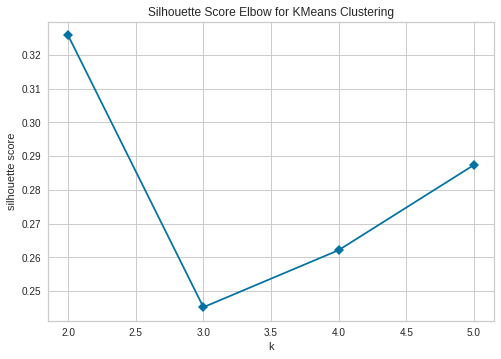

In [134]:
# Import the KElbowVisualizer method 
from yellowbrick.cluster import KElbowVisualizer

# Instantiate a scikit-learn K-Means model
model = KMeans(random_state=0)

# Instantiate the KElbowVisualizer with the number of clusters and the metric 
visualizer = KElbowVisualizer(model, k=(2,6), metric='silhouette', timings=False)

# Fit the data and visualize
visualizer.fit(input)    
visualizer.poof()   

Best silhouette coefficient at cluster size 3

In [135]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(input)

In [142]:
df["labels"] = kmeans.labels_
final_group = df.groupby(['customer', 'labels']).size()
df_result = pd.DataFrame({'count' : final_group}).reset_index()
df_result

,customer,labels,count
0,0,0,3
1,1,0,18
2,1,1,2
3,2,1,1
4,3,0,19
...,...,...,...
12471,10234,2,1
12472,10235,1,1
12473,10236,1,1
12474,10237,1,2


# Lets solve our final problem. What if a customer falls in two different clusters ?  

In [146]:
"""
    For a customer, we will select the cluster which has maximum count
"""
idx = df_result.groupby(["customer"])["count"].transform(max) == df_result["count"]

In [149]:
df_result[idx]

,customer,labels,count
0,0,0,3
1,1,0,18
3,2,1,1
4,3,0,19
7,4,0,22
...,...,...,...
12471,10234,2,1
12472,10235,1,1
12473,10236,1,1
12474,10237,1,2


In [152]:
df_result["labels"].value_counts()

AttributeError: 'DataFrame' object has no attribute 'count_values'